src: https://github.com/suicao/PhoBert-Sentiment-Classification

In [1]:
!nvidia-smi

Sun Dec  6 13:51:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/MyDrive/Uni/DataMining/tq"

Mounted at /content/gdrive
phobert2.ipynb			 preprocessed_lowcase.csv
phobert.ipynb			 segmented.csv
preprocessed_case_sensitive.csv  topic_detection_train.v1.0.csv
preprocessed_for_tfidf_svm.csv


In [2]:
!pip install -q vncorenlp
!pip install -q transformers

     |████████████████████████████████| 2.7MB 5.9MB/s 
     |████████████████████████████████| 1.4MB 2.4MB/s 
     |████████████████████████████████| 890kB 14.9MB/s 
     |████████████████████████████████| 2.9MB 12.8MB/s 


In [ ]:
from transformers import AutoConfig
config = AutoConfig.from_pretrained("vinai/phobert-base", output_hidden_states=True)
config

RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 258,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 1,
  "tokenizer_class": "PhobertTokenizer",
  "type_vocab_size": 1,
  "vocab_size": 64001
}

# Import modules

In [3]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from tqdm import tqdm
tqdm.pandas()
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from transformers import AutoModel, AutoTokenizer, AutoConfig
from transformers import *
from transformers.modeling_utils import * 
#from fairseq.data.encoders.fastbpe import fastBPE
#from fairseq.data import Dictionary
from vncorenlp import VnCoreNLP

#utils
def seed_everything(SEED):
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def adjust_learning_rate(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Data

In [6]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [10]:
line = "CHO_THUÊ CHUNG_CƯ mini SIÊU ĐẸP, SIÊU RẺ"
input_ids = tokenizer.encode(line)
print(input_ids)
print(tokenizer.convert_ids_to_tokens(input_ids))

[0, 5991, 1345, 21038, 1878, 15680, 5991, 1878, 6861, 3876, 22961, 5844, 11473, 53489, 1782, 57679, 1186, 4, 11473, 53489, 1144, 58040, 2]
['<s>', 'CH@@', 'O@@', '_TH@@', 'U@@', 'Ê', 'CH@@', 'U@@', 'NG@@', '_C@@', 'Ư', 'mini', 'SI@@', 'ÊU', 'Đ@@', 'Ẹ@@', 'P@@', ',', 'SI@@', 'ÊU', 'R@@', 'Ẻ', '</s>']


In [11]:
line = "cho_thuê chung_cư mini siêu đẹp, siêu rẻ"
input_ids = tokenizer.encode(line)
print(input_ids)
print(tokenizer.convert_ids_to_tokens(input_ids))

[0, 1347, 39192, 57361, 1574, 5844, 1031, 56234, 1487, 4, 1031, 1455, 2]
['<s>', 'ch@@', 'o_th@@', 'uê', 'chung_cư', 'mini', 'siêu', 'đẹ@@', 'p@@', ',', 'siêu', 'rẻ', '</s>']


In [3]:
''' This is executed once, for producing the preprocessed .csv file 
import regex as re
EMAIL = re.compile(r"([\w0-9_\.-]+)(@)([\d\w\.-]+)(\.)([\w\.]{2,6})")
PHONE = re.compile(r"[0-9]{10,11}")
URL = re.compile(r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))")
DATETIME = re.compile(r"\d{1,2}\s?[/-]\s?\d{1,2}\s?[/-]\s?\d{4}")
PUNC = re.compile(r"[^\w\s,.]") #any chars other than \w \s , .

def preprocess(txt):
    #txt = txt.lower()
    txt = re.sub(EMAIL, ' ', txt)
    txt = re.sub(PHONE, ' ', txt)
    txt = re.sub(URL, ' ', txt)
    txt = re.sub(DATETIME, ' ', txt)
    txt = re.sub('&#?[a-z0-9]+;', ' ', txt)
    txt = re.sub(PUNC, ' ', txt)
    return txt

# Get word segmentator
!mkdir -p vncorenlp/models/wordsegmenter
!wget -q https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget -q https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget -q https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/ 
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

rdrsegmenter = VnCoreNLP('./vncorenlp/VnCoreNLP-1.1.1.jar', annotators="wseg", max_heap_size='-Xmx500m') 

train_df = pd.read_csv('/content/gdrive/MyDrive/Uni/DataMining/tq/topic_detection_train.v1.0.csv', sep='\t', header=None)
train_df.iloc[:,1] = train_df.iloc[:,1].progress_apply(lambda x: preprocess(x) )
train_df.iloc[:,1] = train_df.iloc[:,1].progress_apply(lambda x: ' '.join([' '.join(sent) for sent in rdrsegmenter.tokenize(x)]))

train_df.to_csv('./preprocessed.csv', sep='\t', index=False)
!cp './preprocessed.csv' '/content/gdrive/MyDrive/Uni/DataMining/tq/preprocessed_.csv'
'''

100%|██████████| 15994/15994 [02:50<00:00, 93.84it/s] 


In [19]:
# Get tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

# Load training data
train_df = pd.read_csv('/content/gdrive/MyDrive/Uni/DataMining/tq/preprocessed_case_sensitive.csv', sep='\t', header=None)

# tokenize
X = train_df.iloc[:,1].apply(lambda x: tokenizer.encode(x, max_length=256, padding='max_length', truncation=True) )

# label encoding
label_encoder = LabelEncoder()
y = train_df.iloc[:,0]
y = label_encoder.fit_transform(y) 

cls_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
cls_weights = torch.tensor(cls_weights).float().cuda()
cls_weights = None

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [4]:
seed_everything(42)
splits = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X, y))

#for fold, (train_idx, val_idx) in enumerate(splits):
train_idx, val_idx = splits[0]

train_dataset = torch.utils.data.TensorDataset(torch.tensor(X[train_idx].tolist(),dtype=torch.long), torch.tensor(y[train_idx],dtype=torch.long))
valid_dataset = torch.utils.data.TensorDataset(torch.tensor(X[val_idx].tolist(),dtype=torch.long), torch.tensor(y[val_idx],dtype=torch.long))

train_loader32 = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader32 = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [4]:
seed_everything(42)
splits = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X, y))

#for fold, (train_idx, val_idx) in enumerate(splits):
train_idx, val_idx = splits[0]

# special train set #replace cls 20 with 9
special_train_labels = np.where(y[train_idx]==20, 9, y[train_idx])
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X[train_idx].tolist(),dtype=torch.long), torch.tensor(special_train_labels,dtype=torch.long))
valid_dataset = torch.utils.data.TensorDataset(torch.tensor(X[val_idx].tolist(),dtype=torch.long), torch.tensor(y[val_idx],dtype=torch.long))

train_loader32 = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader32 = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Model

In [8]:
class PhoBertTextClassifier(torch.nn.Module):
    def __init__(self, num_labels):
        super(PhoBertTextClassifier, self).__init__()
        self.num_labels = num_labels
        #self.roberta = RobertaModel(config)
        self.phobert = AutoModel.from_pretrained("vinai/phobert-base", output_hidden_states=True)
        self.clf = torch.nn.Sequential(
            torch.nn.Linear(2*768, 256),
            torch.nn.Dropout(0.1),
            torch.nn.Tanh(),
            torch.nn.Linear(256, self.num_labels)
        )

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, start_positions=None, end_positions=None):
        features = self.phobert(input_ids, attention_mask=attention_mask, position_ids=position_ids, head_mask=head_mask)
        features = torch.cat((features[2][-1][:,0, ...],features[2][-2][:,0, ...]),-1)
        logits = self.clf(features)
        return logits

# Train

In [9]:
phobert_clf = PhoBertTextClassifier(num_labels=23)
phobert_clf.cuda()

# Creating optimizer and lr schedulers
param_optimizer = list(phobert_clf.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=1e-3, correct_bias=False)  # To reproduce BertAdam specific behavior set correct_bias=False

In [7]:
def train_one_epoch(model, train_loader, optimizer):
    model.train()
    sum_loss = 0.
    avg_loss = 0.
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), position=0, leave=True)
    for i, (x_batch, y_batch) in pbar:    
        y_pred = model(x_batch.cuda(), attention_mask=(x_batch!=1).cuda())
        loss = F.cross_entropy(y_pred, y_batch.cuda(), weight=cls_weights)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sum_loss += loss.item()
        avg_loss = sum_loss/(i+1)
        if i%10 == 0: pbar.set_description(f"loss: {avg_loss:.2f}")
    return avg_loss

@torch.no_grad()
def eval(model, valid_loader):
    model.eval()
    sum_loss = 0.
    pred = []
    y = []
    pbar = tqdm(enumerate(valid_loader), total=len(valid_loader), position=0, leave=True, desc='eval epoch')
    for i, (x_batch, y_batch) in pbar:
        y_pred = model(x_batch.cuda(), attention_mask=(x_batch!=1).cuda())
        loss = F.cross_entropy(y_pred, y_batch.cuda(), weight=cls_weights)
        sum_loss += loss.item()
        y_pred = y_pred.squeeze().detach().argmax(dim=1).cpu().numpy()
        pred.extend(y_pred.tolist())
        y.extend(y_batch.tolist())
    return {
        'loss': sum_loss/len(valid_loader), 
        'pred': pred,
        'gt': y,
        'accuracy': round(accuracy_score(y, pred),3)
    }

In [15]:
phobert_clf.phobert.requires_grad_(False)
train_loss = train_one_epoch(phobert_clf, train_loader32, optimizer)
eval_result = eval(phobert_clf, valid_loader32); print('>> accuracy:', eval_result['accuracy'])

eval epoch: 100%|██████████| 100/100 [00:25<00:00,  3.93it/s]

>> accuracy: 0.85


In [16]:
phobert_clf.phobert.requires_grad_(True)
adjust_learning_rate(optimizer, 3e-5)
train_loss = train_one_epoch(phobert_clf, train_loader32, optimizer)
eval_result = eval(phobert_clf, valid_loader32); print('>> accuracy:', eval_result['accuracy'])

eval epoch: 100%|██████████| 100/100 [00:25<00:00,  3.93it/s]

>> accuracy: 0.874


In [17]:
adjust_learning_rate(optimizer, 1e-5)
train_loss = train_one_epoch(phobert_clf, train_loader32, optimizer)
eval_result = eval(phobert_clf, valid_loader32); print('>> accuracy:', eval_result['accuracy'])

eval epoch: 100%|██████████| 100/100 [00:25<00:00,  3.93it/s]

>> accuracy: 0.88


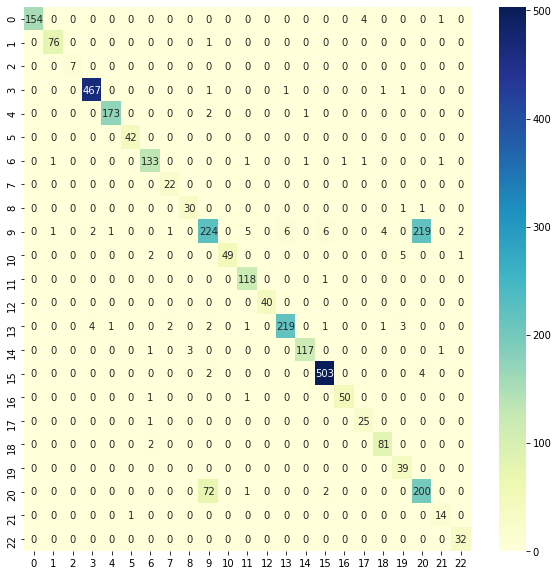

In [18]:
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(eval_result['gt'], eval_result['pred']), cmap="YlGnBu", annot=True, fmt="d")
plt.show()

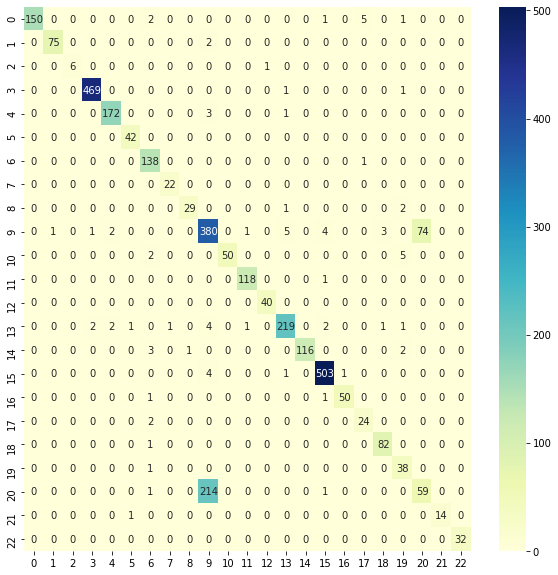

In [14]:
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(eval_result['gt'], eval_result['pred']), cmap="YlGnBu", annot=True, fmt="d")
plt.show()

In [27]:
dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

{'__label__Chinh_tri': 0,
 '__label__Con_nguoi_va_xa_hoi': 1,
 '__label__Cong_nghe_moi': 2,
 '__label__Do_an_va_do_uong': 3,
 '__label__Du_lich': 4,
 '__label__Giai_tri': 5,
 '__label__Giao_duc': 6,
 '__label__Giao_thong': 7,
 '__label__Khoa_hoc': 8,
 '__label__Kinh_doanh_va_Cong_nghiep': 9,
 '__label__Lam_dep_va_the_hinh': 10,
 '__label__Mang_internet_va_vien_thong': 11,
 '__label__May_tinh_va_thiet_bi_dien_tu': 12,
 '__label__Mua_sam': 13,
 '__label__Nghe_thuat': 14,
 '__label__Nha_dat': 15,
 '__label__Nha_va_vuon': 16,
 '__label__Phap_luat': 17,
 '__label__Sach': 18,
 '__label__Suc_khoe_va_benh_tat': 19,
 '__label__Tai_chinh': 20,
 '__label__The_thao': 21,
 '__label__Thoi_quen_va_so_thich': 22}